## Define network

In [ ]:
from src.attention import Attention

In [1]:
import torch
from torch import nn
from src.transformers import ViT

torch.manual_seed(0)


class Net(nn.Module):
    def __init__(self, embed_dim=8):
        super(Net, self).__init__()

        self.encoder = ViT(embed_dim=embed_dim, n_blocks=2, n_heads=4)
        self.decoder = ViT(embed_dim=embed_dim,n_blocks=2, n_heads=4,
                           img_shape=(1, 2, embed_dim), patch_size=2)
        
        self.mapper = nn.Linear(3, embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 3),
            nn.Sigmoid()
        )

    def forward(self, x, p):
        b = x.shape[0]
        x = self.encoder(x)
        
        p = self.mapper(p).view(b, 1, 1, -1)
        x = x[:, 0, :].view(b, 1, 1, -1)
        x = torch.cat((p,x), dim=2)

        x = self.decoder(x)
        x = self.mlp(x[:, 0, :])

        return x

In [3]:
T = 2
torch.tril(torch.ones(T, T)).view(1, 1, T, T).shape

torch.Size([1, 1, 2, 2])

## Define dataset anda dataloader

In [2]:
from src.datasets import PolyMNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

train = PolyMNIST(csv_file="mnist/train/polygon-mnist.csv",
                  transform=ToTensor())

test = PolyMNIST(csv_file="mnist/test/polygon-mnist.csv",
                  transform=ToTensor())

train_loader = DataLoader(train, batch_size=60, shuffle=True)
test_loader = DataLoader(test, batch_size=60, shuffle=False)

## Train

In [5]:
from torch.optim import Adam
from torch.nn import MSELoss
from tqdm.notebook import trange, tqdm

N_EPOCHS = 30
LR = 0.0007

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(
    device) if torch.cuda.is_available() else "cpu"
print("Using device: ", device, f"({device_name})")

model = Net().to(device)
optimizer = Adam(model.parameters(), lr=LR)
criterion = MSELoss()

model.train()
train_loss = 0.0
for epoch in trange(N_EPOCHS, desc="Training"):

    desc = f"Epoch {epoch + 1} in training"

    train_loss = 0.0

    for batch in tqdm(train_loader, desc=desc, leave=False):
        image, _, polygon = batch

        image = image.to(device)
        polygon = polygon.to(device)
        
        # That's lame
        # I urge to learn how to do masking in the attention and use it
        # At least the loss is decreasing
        loss = None
        for i in range(11):
            pred = model(image, polygon[:, i, :])

            if (loss is None):
                loss = criterion(pred, polygon[:, (i + 1), :])
            else:
                loss += criterion(pred, polygon[:, (i + 1), :])

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item() / len(train_loader)

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

Using device:  cuda (Quadro M5000)


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1 in training:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, _, p = batch
        x, p = x.to(device), p.to(device)
        
        loss = None
        for i in range(11):
            pred = model(x, p[:, i, :])

            if loss is None:
                 loss = criterion(pred, p[:, (i + 1), :])
            else:
                loss += criterion(pred, p[:, (i + 1), :])

        test_loss += loss.detach().cpu().item() / len(test_loader)

        # correct += torch.sum(torch.argmax(y_hat, dim=1)
        #                      == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    # print(f"Test accuracy: {correct / total * 100:.2f}%")

Testing:   0%|          | 0/167 [00:00<?, ?it/s]

Test loss: 0.04


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

batch_images, _, poly = next(iter(test_loader))
idx = 0

img = batch_images[idx].numpy()[0] * 255
img = img.astype(np.uint8)


np_out = np.zeros((28,28, 3))
np_out[:,:, 1] = np.copy(img)

pts = poly[idx].numpy()#.reshape((-1, 3))
pts = np.delete(pts, 0, 1).reshape(-1, 1, 2) * 28
pts = pts[1:7].astype(np.int32)
image = cv2.polylines(np_out, [pts], True, (255,0,0), 1)

plt.title("original")
plt.imshow(image)

NameError: name 'test_loader' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.1377, 0.2718, 0.4272, 0.5817, 0.7351, 0.8810], device='cuda:0')


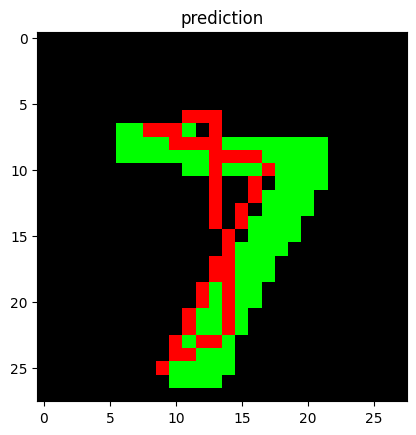

In [ ]:
with torch.no_grad():
    inputs = torch.zeros(1, 3).to(device)
    image = batch_images[idx].reshape(1, 1, 28, 28).to(device)

    poly = []
    for i in range(10):
        pred = model(image, inputs)

        if (pred[0][0] > 0.95):
            break
        poly.append(pred)
        inputs = pred
    poly = torch.cat(poly)

    np_out = np.zeros((28,28, 3))
    np_out[:,:, 1] = np.copy(img)
    
    print(poly[:, 0])
    pts = poly.to('cpu').numpy() * 28
    pts = np.delete(pts, 0, 1).reshape(-1, 1, 2)
    pts = pts.astype(np.int32)
    image = cv2.polylines(np_out, [pts], True, (255,0,0), 1)
    
    plt.title("prediction")
    plt.imshow(image)

## Save

In [ ]:
path = "checkpoints/polygon_004.pth"
torch.save(model.state_dict(), path)